## Water Demand Tutorial

In [24]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import folium
import scipy
import seaborn as sns

# Set Seaborn style and color palette
sns.set_style("darkgrid")
sns.set_palette("husl")

# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles


# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    ax.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=ax.projection)
    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-4500, '20 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-12500, sby-4500, '10 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-24500, sby-4500, '0 km', transform=ax.projection, fontsize=8)

In [25]:
# load the outline of UK for a backdrop
outline = gpd.read_file(os.path.abspath('data_files/Outline.shp'))

In [26]:
# Load dmas
dmas = gpd.read_file(os.path.abspath('data_files/dma_polygons.shp'))

In [27]:
dmas.head(10)

,dma,geometry
0,0,"POLYGON ((413468.26203 330979.09422, 414348.00..."
1,1,"POLYGON ((415272.74183 327943.78061, 414176.00..."
2,2,"POLYGON ((417373.00084 327843.99961, 417196.50..."
3,3,"POLYGON ((416243.69853 332081.94897, 414412.00..."
4,4,"POLYGON ((419310.00084 331616.99962, 419137.54..."
5,5,"POLYGON ((419109.66184 329992.88562, 416199.32..."


In [28]:
# Load properties
properties = gpd.read_file(os.path.abspath('data_files/properties.shp'))

In [29]:
properties.head(10)

,UPRN,X_COORDINA,Y_COORDINA,join_idx,dist,line_id,demographi,daily_cons,geometry
0,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000)
1,1.000082e+10,419072.0,330227.0,125,25.489050,648,6,714.363137,POINT (419072.00000 330227.00000)
2,1.000082e+10,419314.0,330228.0,125,197.117215,648,3,509.669651,POINT (419314.00000 330228.00000)
3,1.000082e+10,419341.0,330237.0,125,224.847624,648,4,208.376374,POINT (419341.00000 330237.00000)
4,1.000082e+10,419347.0,330214.0,125,219.497755,648,4,487.279475,POINT (419347.00000 330214.00000)
5,1.000082e+10,419273.0,330252.0,125,180.326021,648,2,347.930265,POINT (419273.00000 330252.00000)
6,1.000082e+10,419205.0,330201.0,125,97.289132,648,4,378.594987,POINT (419205.00000 330201.00000)
7,1.000082e+10,419207.0,330208.0,125,104.147142,648,3,503.374523,POINT (419207.00000 330208.00000)
8,1.000082e+10,419349.0,330188.0,125,211.901056,648,4,337.902536,POINT (419349.00000 330188.00000)
9,1.000082e+10,419229.0,330205.0,125,115.959898,648,3,574.491170,POINT (419229.00000 330205.00000)


In [30]:
# Append PCC properties geodataframe

# Load the CSV file
mock_pcc = pd.read_csv('data_files/monthly_water_consumptions.csv')  

# Perform the merge
pcc_props_merge = properties.merge(mock_pcc, on='UPRN')

In [31]:
pcc_props_merge.head(10)

,UPRN,X_COORDINA,Y_COORDINA,join_idx,dist,line_id,demographi,daily_cons,geometry,Unnamed: 0,yearmonth,value
0,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),0,2020-04,436.234385
1,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),1,2020-05,483.750010
2,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),2,2020-06,442.033893
3,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),3,2020-07,469.888711
4,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),4,2020-08,463.560941
5,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),5,2020-09,446.214549
6,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),6,2020-10,457.614289
7,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),7,2020-11,492.313518
8,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),8,2020-12,476.311289
9,1.000082e+10,418579.0,331661.0,126,75.314295,649,5,346.641703,POINT (418579.00000 331661.00000),9,2021-01,462.691955


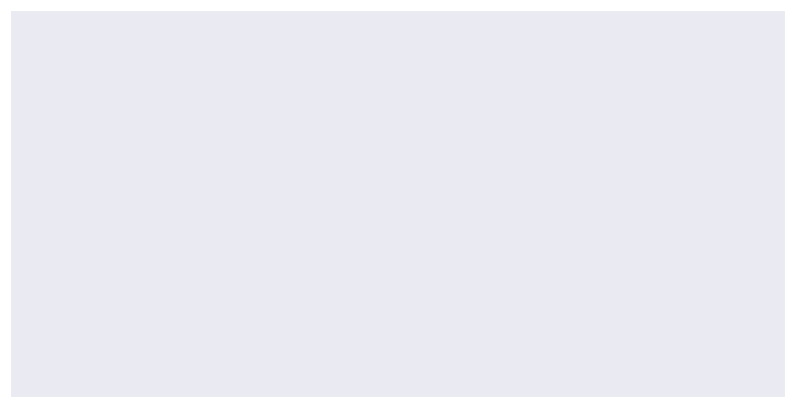

In [32]:
myFig = plt.figure(figsize=(10, 10))  # create a figure of size 10x10 (representing the page size in inches)

myCRS = ccrs.TransverseMercator(27700)  # create a Universal Transverse Mercator reference system to transform our data.

ax = plt.axes(projection=myCRS)  # finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

In [33]:
# first, we just add the outline using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature) # add the features created to the map.

In [34]:
pcc_props_merge = pcc_props_merge.to_crs(myCRS)

print(dmas.crs == outline.crs) # test if the crs is the same 

False


In [35]:
# Define the colour map
my_cmap = 'viridis'  # Replace with the desired color map name, e.g., 'viridis', 'cividis', 'coolwarm', etc.

# Plot the 'merged_landuse' GeoDataFrame on the existing map
pcc_props_merge.plot(column='value', cmap=my_cmap, linewidth=0.5, edgecolor='k', alpha=0.25, ax=ax)

<GeoAxes: >

<Figure size 640x480 with 0 Axes>

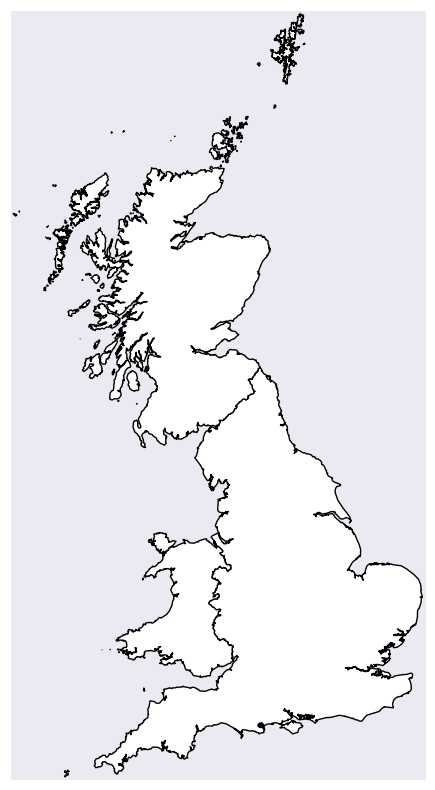

In [36]:
# using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=myCRS) # because total_bounds 
# gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

myFig ## re-draw the figure

In [ ]:
myFig # to show the updated figure

In [ ]:
# using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=myCRS) # because total_bounds 
# gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

#myFig ## uncomment if you would like to see a preview of the map

In [ ]:
# get the number of unique water companies we have in the dataset
num_wrz = len(wrz.COMPANY.unique())
print('Number of unique features: {}'.format(num_wrz))

In [ ]:
# pick colours for the individual water companies- generate random RGB colors
num_colours = num_wrz  # Number of colours to generate
company_colours = sns.color_palette("husl", n_colors=num_colours)  # Use Seaborn color palette

In [ ]:
# get a list of unique names for the company boundaries
company_names = list(wrz.COMPANY.unique())
company_names.sort() # sort the companies alphabetically by name

In [ ]:
# next, add the company outlines to the map using the colours that we've picked.
for ii, name in enumerate(company_names):
    feat = ShapelyFeature(wrz.loc[wrz['COMPANY'] == name, 'geometry'], # first argument is the geometry
                          myCRS, # second argument is the CRS
                          edgecolor='k', # outline the feature in black
                          facecolor=company_colours[ii], # set the face color to the corresponding color from the list
                          linewidth=1, # set the outline width to be 1 pt
                          alpha=0.25) # set the alpha (transparency) to be 0.25 (out of 1)
    ax.add_feature(feat) # once we have created the feature, we have to add it to the map using ax.add_feature()

In [ ]:
#myFig # to show the updated figure

In [ ]:
# Add vertical gridlines
ax.vlines(x=[100000, 200000, 300000, 400000, 500000, 600000, 700000],
          ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],
          color='gray', linestyle=':', linewidth=0.5)

# Add horizontal gridlines
ax.hlines(y=[100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1100000, 1200000],
          xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
          color='gray', linestyle=':', linewidth=0.5)

# Add labels to x-axis
x_ticks = [100000, 200000, 300000, 400000, 500000, 600000, 700000]
for x in x_ticks:
    ax.text(x, ax.get_ylim()[0] - 50000, str(x), ha='center', va='top', fontsize=8)

# Add labels to y-axis
y_ticks = [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1100000, 1200000]
for y in y_ticks:
    ax.text(ax.get_xlim()[0] - 50000, y, str(y), ha='right', va='center', fontsize=8)

ax.set_xlabel('X Axis Label')
ax.set_ylabel('Y Axis Label')

myFig # to show the updated figure

In [ ]:
print(wrz.crs == outline.crs) # test if the crs is the same 

In [ ]:
wrz.loc[1]

In [ ]:
# Append PCC for 2019 to 2020 to the wrz geodataframe

# Load the CSV file
pr24_hist_pcc = pd.read_csv('data_files/pr24_hist_pcc.csv')  

# Perform the merge
merged = wrz.merge(pr24_hist_pcc[['Company', '2019-20']], how='left', left_on='Acronym', right_on='Company')

# Drop the unnecessary columns & rename the merged column
merged.drop(['Company'], axis=1, inplace=True)
merged.rename(columns={'2019-20': '2019-20_from_CSV'}, inplace=True)

# Update the wrz GeoDataFrame with the merged column
wrz['2019-20'] = merged['2019-20_from_CSV']

In [ ]:
#Add chloropleth map
# Create the chloropleth map
wrz.plot(column='2019-20', cmap='viridis', linewidth=0.8, edgecolor='black', legend=True, figsize=(10, 10))

# Set plot title and axis labels
plt.title('Chloropleth Map of 2019-20')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
wrz.loc[1]

In [ ]:
# Append PCC for 2011 to 2012 to the wrz geodataframe
# Load the GeoDataFrame
# wrz = gpd.read_file(os.path.abspath('data_files/WaterSupplyAreas_incNAVs v1_4.shp'))  

# Load the CSV file
pr24_hist_pcc = pd.read_csv('data_files/pr24_hist_pcc.csv') 

# Perform the merge
merged = wrz.merge(pr24_hist_pcc[['Company', '2011-12']], how='left', left_on='Acronym', right_on='Company')

# Drop the unnecessary columns
merged.drop(['Company'], axis=1, inplace=True)

# Rename the merged column
merged.rename(columns={'2011-12': '2011-12_from_CSV'}, inplace=True)

# Update the wrz GeoDataFrame with the merged column
wrz['2011-12'] = merged['2011-12_from_CSV']

# Update the wrz GeoDataFrame with the merged column
wrz['2011-12'] = merged['2011-12_from_CSV']

# Check the updated GeoDataFrame
wrz.loc[1]

In [ ]:
# Create the chloropleth map
wrz.plot(column='2011-12', cmap='viridis', linewidth=0.8, edgecolor='black', legend=True, figsize=(10, 10))

# Set plot title and axis labels
plt.title('Chloropleth Map of 2011-12')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
legend_kwds={'caption': 'Per Capita Water Consumption'} # set the caption to a longer explanation

In [ ]:
# Create a Folium map using the existing GeoDataFrame
m = folium.Map()

m = merged.explore('2019-20', # show the PCC for this period column
                   cmap='YlOrRd', # use the 'plasma' colormap from matplotlib
                   legend_kwds={'caption': 'PCC for 2019-20'} # set the caption to a longer explanation
                  )

airport_args = {
    'm': m, # add the markers to the same map we just created
    'marker_type': 'marker', # use a marker for the points, instead of a circle
    'popup': True, # show the information as a popup when we click on the marker
    'legend': False, # don't show a separate legend for the point layer
    'marker_kwds': {'icon': folium.Icon(color='red', icon='dot', prefix='fa')} # make the markers red with a dot icon from FA
}
m